# Multiple Linear Regression: Application on FARS Dataset

## Mathematical Formulation

When modeling the relationship between a dependent variable $y$ and multiple independent variables $x_1, x_2, \dots, x_n$, the linear equation can be written as:
\begin{equation}
y_i=\beta_0+\beta_1 x_{i 1}+\beta_2 x_{i 2}+\cdots+\beta_n x_{i n}+\epsilon_i
\end{equation}

where:

- $y_i$ is the observed value of the dependent variable for the $i^{th}$ observation.

- $x_1, x_2, \dots, x_n$ are the values of the independent variables for the $i^{th}$ observation.

- $\beta_0, \beta_1, \beta_n$ are the regression coefficients, with $\beta_0$ being the y-intercept.

- $\epsilon_i$ is the error term for the $i^{th}$ observation, capturing the difference between the observed value and the value predicted by the model.


The requirement here is to find the $\beta_i$ that minimizes the meas square error of $\epsilon_i$. 
The above could be solved in multiple ways. However, one easy way to solve it is through matrix multiplication since CPU's can deal faster with matrix manipulation.

### Matrix Notation

Given:

- $\boldsymbol{X}$ is the design matrix of size $m \times (n + 1)$.

- $\boldsymbol{y}$ is a column vector of size $m \times 1$ containing the dependent variable values.

- $\boldsymbol{\beta}$ is a column vector of size $(n + 1) \times 1$ containing the regression coefficients.

- $\boldsymbol{\epsilon}$  is a column vector of size $m \times 1$ representing the errors.



The relationship is given by:
\begin{equation}
\large{y} = \large{X} \beta + \epsilon
\end{equation}

To determine the value of $\beta$, one might think to rearrange the equation as:

\begin{equation}
\beta = \frac{\large{y}}{\large{X}}
\end{equation}

However, this representation is not accurate in the context of matrix operations. The inaccuracy arises due to the nature of matrices and how they are manipulated. Here's a breakdown of the issues:


- **Matrix Division:** In the realm of matrices, there isn't a direct concept of division like there is with regular numbers. So, saying $\beta = \frac{y}{X}$ doesn't have a straightforward meaning. 

- **Matrix Multiplication:** Matrix multiplication is not commutative. This means that the product $AB$ is not necessarily the same as the product $BA$. So, even if we were to try to "isolate" $\beta$ by some matrix operation, it wouldn't be as simple as dividing both sides by $X$. 

- **Correct Approach:** The correct way to "isolate" $\beta$ when dealing with matrices is to multiply both sides of the equation by the inverse of $X$ (assuming $X$ is invertible). The equation would look something like: $\beta = X^{-1}y$. 
    Note that this equation assumes that $X$ is a square matrix and has an inverse. If $X$ is not square, or doesn't have an inverse, other methods like the Moore-Penrose pseudoinverse would be used to estimate $\beta$. 
    
- **Dimensionality:** Even if we were to entertain the idea of matrix division, the dimensions must be compatible. In the equation $y = X\beta + \epsilon$, $y$ is a column vector of size $m \times 1$, $X$ is a matrix of size $m \times n$, and $\beta$ is a column vector of size $n \times 1$. Dividing an $m \times 1$ vector by an $m \times n$ matrix doesn't produce a consistent result in terms of matrix dimensions.

The reason we use the equation $ \boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $ instead of 
$ \boldsymbol{\beta} = \mathbf{X}^{-1} \mathbf{y} $ is due to the structure and properties of the design matrix \( \mathbf{X} \) in linear regression.


- **Non-Square Matrix:** In most real-world applications of linear regression, $\mathbf{X}$ is not a square matrix. It usually has more rows (observations) than columns (predictors). Only square matrices possess inverses in the traditional sense. Therefore, $\mathbf{X}^{-1}$ doesn't exist for these cases.

- **Pseudo-Inverse:** The expression $(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T$ is known as the Moore-Penrose pseudo-inverse of $\mathbf{X}$. This pseudo-inverse provides a means to approximate an inverse. 

- **Projection onto Column Space:** The term $\mathbf{X}^T \mathbf{y}$ can be interpreted as projecting the response vector $\mathbf{y}$ onto the column space of $\mathbf{X}$. 

- **Minimization of Residuals:** The expression $(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T$ originates from differentiating the sum of squared residuals with respect to $\boldsymbol{\beta}$ and setting it to zero.


We'll be applying this concept to the FARS dataset. Managed by the U.S. National Highway Traffic Safety Administration (NHTSA), the Fatality Analysis Reporting System (FARS) provides an extensive record of fatal motor vehicle crashes in the U.S. and Puerto Rico since 1975.

## Code

### Describe the FARS (Fatality Analysis Reporting System) dataset

Our analysis will encompass six specific tables within this dataset. The tables and their respective descriptions are as follows:

- Person: This table provides detailed information on the individuals involved in the accident.
- Drugs: This table presents data on post-mortem toxicology results, indicating the presence of drugs in the bloodstream of the deceased.
- Race: This table delineates the ethnic background of the individuals involved in the accident.
- Vision: This table offers insights into the visual clarity at the accident site.
- Weather: This table details the meteorological conditions at the time of the accident.
- Maneuver: This table ascertains whether the drivers were executing a maneuver at the time of the incident and provides specifics about the maneuver in question.

In [2]:
#import required libraries
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

#inline plots
%matplotlib inline

# Set Seaborn style to "whitegrid" for a white background with grid lines
sns.set_style("whitegrid")

#supress warnings!
warnings.simplefilter(action='ignore', category=Warning)
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

print("required libraries loaded successfully!")

required libraries loaded successfully!


In [9]:
# Define the directory where the datasets are
directory = "D:\\OneDrive - Virginia Tech\\01.PhD\\02.CourseMaterials\\04.Fall2023\\02.CS5805_MachineLearning\\04.Projects\\src\\data\\FARS2021NationalCSV"

# Check if the directory exists
if not os.path.exists(directory):
    raise ValueError("The directory does not exist.")

# Define files and their respective key columns
files_and_keys = {
    "person.csv": ["ST_CASE", "VEH_NO", "PER_NO"],
    "drugs.csv": ["ST_CASE", "VEH_NO", "PER_NO"],
    "maneuver.csv": ["ST_CASE", "VEH_NO"],
    "race.csv": ["ST_CASE", "VEH_NO", "PER_NO"],
    "vision.csv": ["ST_CASE", "VEH_NO"],
    "weather.csv": ["ST_CASE"]
}

# Create an initial empty DataFrame
merged_df = None

for csv_file, key_cols in files_and_keys.items():
    file_path = os.path.join(directory, csv_file)
    if not os.path.exists(file_path):
        print(f"File {csv_file} does not exist. Skipping...")
        continue

    try:
        temp_df = pd.read_csv(file_path, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        print(f"Could not decode file {csv_file} with ISO-8859-1 encoding. Skipping...")
        continue

    # If merged_df is empty, initialize it with the first CSV data
    if merged_df is None:
        merged_df = temp_df
    else:
        # Find common key columns between merged_df and temp_df
        merged_keys = [col for col in key_cols if col in merged_df.columns and col in temp_df.columns]

        # Only proceed if there are common keys to merge on
        if merged_keys:
            # Drop non-key columns from temp_df that already exist in merged_df
            drop_cols = [col for col in temp_df.columns if col in merged_df.columns and col not in merged_keys]
            temp_df = temp_df.drop(columns=drop_cols)

            # Merge based on the common key columns
            merged_df = pd.merge(merged_df, temp_df, on=merged_keys, how='outer')
            
print("Files merged and loaded as 'merged_df' successfully!")
merged_df.head()

Files merged and loaded as 'merged_df' successfully!


,STATE,STATENAME,ST_CASE,VEH_NO,PER_NO,VE_FORMS,COUNTY,MONTH,MONTHNAME,DAY,DAYNAME,HOUR,HOURNAME,MINUTE,MINUTENAME,HARM_EV,HARM_EVNAME,MAN_COLL,MAN_COLLNAME,SCH_BUS,SCH_BUSNAME,MOD_YEAR,MOD_YEARNAME,VPICMAKE,VPICMAKENAME,VPICMODEL,VPICMODELNAME,VPICBODYCLASS,VPICBODYCLASSNAME,MAKE,MAKENAME,BODY_TYP,BODY_TYPNAME,ICFINALBODY,ICFINALBODYNAME,GVWR_FROM,GVWR_FROMNAME,GVWR_TO,GVWR_TONAME,TOW_VEH,TOW_VEHNAME,AGE,AGENAME,SEX,SEXNAME,PER_TYP,PER_TYPNAME,INJ_SEV,INJ_SEVNAME,SEAT_POS,SEAT_POSNAME,REST_USE,REST_USENAME,REST_MIS,REST_MISNAME,HELM_USE,HELM_USENAME,HELM_MIS,HELM_MISNAME,AIR_BAG,AIR_BAGNAME,EJECTION,EJECTIONNAME,EJ_PATH,EJ_PATHNAME,EXTRICAT,EXTRICATNAME,DRINKING,DRINKINGNAME,ALC_DET,ALC_DETNAME,ALC_STATUS,ALC_STATUSNAME,ATST_TYP,ATST_TYPNAME,ALC_RES,ALC_RESNAME,DRUGS,DRUGSNAME,DRUG_DET,DRUG_DETNAME,DSTATUS,DSTATUSNAME,HOSPITAL,HOSPITALNAME,DOA,DOANAME,DEATH_DA,DEATH_DANAME,DEATH_MO,DEATH_MONAME,DEATH_YR,DEATH_YRNAME,DEATH_HR,DEATH_HRNAME,DEATH_MN,DEATH_MNNAME,DEATH_TM,DEATH_TMNAME,LAG_HRS,LAG_HRSNAME,LAG_MINS,LAG_MINSNAME,STR_VEH,LOCATION,LOCATIONNAME,WORK_INJ,WORK_INJNAME,HISPANIC,HISPANICNAME,RUR_URB,RUR_URBNAME,FUNC_SYS,FUNC_SYSNAME,SPEC_USE,SPEC_USENAME,EMER_USE,EMER_USENAME,ROLLOVER,ROLLOVERNAME,IMPACT1,IMPACT1NAME,FIRE_EXP,FIRE_EXPNAME,MAK_MOD,MAK_MODNAME,DRUGSPEC,DRUGSPECNAME,DRUGRES,DRUGRESNAME,MANEUVER,MANEUVERNAME,RACE,RACENAME,ORDER,ORDERNAME,MULTRACE,MULTRACENAME,VISION,VISIONNAME,WEATHER,WEATHERNAME
0,1.0,Alabama,10001,1,1.0,2.0,115.0,2.0,February,12.0,12.0,22.0,10:00pm-10:59pm,10.0,10,12.0,Motor Vehicle In-Transport,2.0,Front-to-Front,0.0,No,2016.0,2016,483.0,Jeep,1947.0,Patriot,7.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,2.0,Jeep / Kaiser-Jeep / Willys- Jeep,14.0,"Compact Utility (Utility Vehicle Categories ""S...",0.0,Not Applicable,11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",0.0,No Trailing Units,31.0,31 Years,2.0,Female,1.0,Driver of a Motor Vehicle In-Transport,4.0,Fatal Injury (K),11.0,"Front Seat, Left Side",2.0,Lap Belt Only Used,0.0,No Indication of Misuse,20.0,Not Applicable,7.0,None Used/Not Applicable,8.0,Deployed- Combination,0.0,Not Ejected,0.0,Ejection Path Not Applicable,9.0,Unknown,8.0,Not Reported,9.0,Not Reported,2.0,Test Given,1.0,Blood,0.0,0.000 % BAC,8.0,Not Reported,8.0,Not Reported,2.0,Test Given,0.0,Not Transported for Treatment,7.0,Died at Scene,12.0,12,2.0,February,2021.0,2021,22.0,22:00-22:59,10.0,10,2210.0,2210,0.0,0,0.0,0,0.0,0.0,Occupant of a Motor Vehicle,0.0,No,7.0,Non-Hispanic,2.0,Urban,1.0,Interstate,0.0,No Special Use Noted,0.0,Not Applicable,0.0,No Rollover,12.0,12 Clock Point,0.0,No or Not Reported,2407.0,Jeep / Kaiser-Jeep / Willys- Jeep Patriot,1.0,Whole Blood,600.0,DELTA 9,98.0,Not Reported,2.0,Black or African American,1.0,1,0.0,No,0.0,No Obstruction Noted,2,Rain
1,1.0,Alabama,10001,1,2.0,2.0,115.0,2.0,February,12.0,12.0,22.0,10:00pm-10:59pm,10.0,10,12.0,Motor Vehicle In-Transport,2.0,Front-to-Front,0.0,No,2016.0,2016,483.0,Jeep,1947.0,Patriot,7.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,2.0,Jeep / Kaiser-Jeep / Willys- Jeep,14.0,"Compact Utility (Utility Vehicle Categories ""S...",0.0,Not Applicable,11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",0.0,No Trailing Units,3.0,3 Years,2.0,Female,2.0,Passenger of a Motor Vehicle In-Transport,2.0,Suspected Minor Injury (B),21.0,"Second Seat, Left Side",10.0,Child Restraint System - Forward Facing,1.0,"Yes, Indication of Misuse",20.0,Not Applicable,7.0,None Used/Not Applicable,20.0,Not Deployed,0.0,Not Ejected,0.0,Ejection Path Not Applicable,9.0,Unknown,8.0,Not Reported,9.0,Not Reported,0.0,Test Not Given,0.0,Test Not Given,996.0,Test Not Given,8.0,Not Reported,8.0,Not Reported,0.0,Test Not Given,5.0,EMS Ground,0.0,Not Applicable,88.0,Not Applicable (Non-Fatal),88.0,Not Applicable (Non-Fatal),8888.0,Not Applicable (Non-fatal),88.0,Not Applicable (Non-fatal),88.0,Not Applicable (Non-fata

The variables description is provided [here](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813417)

In [17]:
merged_df["WEATHERNAME"].unique()

array(['Rain', 'Clear', 'Cloudy', 'Fog, Smog, Smoke',
       'Reported as Unknown', 'Severe Crosswinds', 'Snow', 'Blowing Snow',
       'Not Reported', 'Freezing Rain or Drizzle', 'Other',
       'Blowing Sand, Soil, Dirt', 'Sleet or Hail'], dtype=object)

In [54]:
# Extract potential prefixes
potential_prefixes = [col for col in merged_df.columns if not col.endswith('NAME')]

# Identify columns with the suffix "NAME"
name_columns = [col for col in merged_df.columns if col.endswith('NAME')]

# Filter out prefixes that don't have a corresponding 'PREFIXNAME' column
valid_prefixes = [prefix for prefix in potential_prefixes if prefix + 'NAME' in merged_df.columns]

# Create dictionaries for each valid pair
dictionaries = {}
for prefix in valid_prefixes:
    name_col = prefix + 'NAME'
    
    # Filter out rows with nan values in either column
    filtered_df = merged_df.dropna(subset=[prefix, name_col])
    
    dictionaries[prefix] = dict(zip(filtered_df[prefix], filtered_df[name_col]))
    
# Drop these columns from the DataFrame
df = merged_df.drop(columns=name_columns)

In [28]:
df.head()

,STATE,ST_CASE,VEH_NO,PER_NO,VE_FORMS,COUNTY,MONTH,DAY,HOUR,MINUTE,HARM_EV,MAN_COLL,SCH_BUS,MOD_YEAR,VPICMAKE,VPICMODEL,VPICBODYCLASS,MAKE,BODY_TYP,ICFINALBODY,GVWR_FROM,GVWR_TO,TOW_VEH,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,HELM_USE,HELM_MIS,AIR_BAG,EJECTION,EJ_PATH,EXTRICAT,DRINKING,ALC_DET,ALC_STATUS,ATST_TYP,ALC_RES,DRUGS,DRUG_DET,DSTATUS,HOSPITAL,DOA,DEATH_DA,DEATH_MO,DEATH_YR,DEATH_HR,DEATH_MN,DEATH_TM,LAG_HRS,LAG_MINS,STR_VEH,LOCATION,WORK_INJ,HISPANIC,RUR_URB,FUNC_SYS,SPEC_USE,EMER_USE,ROLLOVER,IMPACT1,FIRE_EXP,MAK_MOD,DRUGSPEC,DRUGRES,MANEUVER,RACE,ORDER,MULTRACE,VISION,WEATHER
0,1.0,10001,1,1.0,2.0,115.0,2.0,12.0,22.0,10.0,12.0,2.0,0.0,2016.0,483.0,1947.0,7.0,2.0,14.0,0.0,11.0,11.0,0.0,31.0,2.0,1.0,4.0,11.0,2.0,0.0,20.0,7.0,8.0,0.0,0.0,9.0,8.0,9.0,2.0,1.0,0.0,8.0,8.0,2.0,0.0,7.0,12.0,2.0,2021.0,22.0,10.0,2210.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,0.0,0.0,12.0,0.0,2407.0,1.0,600.0,98.0,2.0,1.0,0.0,0.0,2
1,1.0,10001,1,2.0,2.0,115.0,2.0,12.0,22.0,10.0,12.0,2.0,0.0,2016.0,483.0,1947.0,7.0,2.0,14.0,0.0,11.0,11.0,0.0,3.0,2.0,2.0,2.0,21.0,10.0,1.0,20.0,7.0,20.0,0.0,0.0,9.0,8.0,9.0,0.0,0.0,996.0,8.0,8.0,0.0,5.0,0.0,88.0,88.0,8888.0,88.0,88.0,8888.0,999.0,99.0,0.0,0.0,8.0,0.0,2.0,1.0,0.0,0.0,0.0,12.0,0.0,2407.0,0.0,0.0,98.0,0.0,1.0,0.0,0.0,2
2,1.0,10001,2,1.0,2.0,115.0,2.0,12.0,22.0,10.0,12.0,2.0,0.0,2021.0,485.0,1962.0,7.0,51.0,14.0,0.0,11.0,11.0,0.0,25.0,1.0,1.0,4.0,11.0,3.0,0.0,20.0,7.0,8.0,0.0,0.0,9.0,0.0,9.0,2.0,1.0,0.0,0.0,8.0,2.0,0.0,7.0,12.0,2.0,2021.0,22.0,10.0,2210.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,0.0,0.0,12.0,0.0,51404.0,1.0,1.0,98.0,4.0,1.0,0.0,0.0,2
3,1.0,10002,1,1.0,1.0,73.0,2.0,11.0,18.0,0.0,25.0,0.0,0.0,2004.0,515.0,2475.0,13.0,59.0,4.0,0.0,11.0,11.0,0.0,34.0,2.0,1.0,4.0,11.0,3.0,0.0,20.0,7.0,8.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,996.0,0.0,8.0,0.0,0.0,7.0,11.0,2.0,2021.0,18.0,0.0,1800.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,0.0,0.0,11.0,0.0,59031.0,0.0,0.0,98.0,2.0,1.0,0.0,0.0,2
4,1.0,10002,1,2.0,1.0,73.0,2.0,11.0,18.0,0.0,25.0,0.0,0.0,2004.0,515.0,2475.0,13.0,59.0,4.0,0.0,11.0,11.0,0.0,34.0,1.0,2.0,4.0,13.0,3.0,0.0,20.0,7.0,8.0,0.0,0.0,9.0,8.0,9.0,0.0,0.0,996.0,8.0,8.0,0.0,0.0,7.0,11.0,2.0,2021.0,18.0,0.0,1800.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,0.0,0.0,11.0,0.0,59031.0,0.0,0.0,98.0,2.0,1.0,0.0,0.0,2


### Describtive Statistics

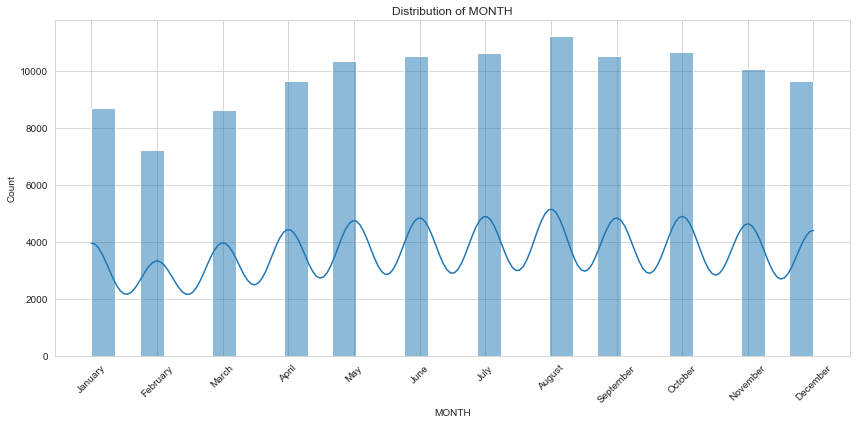

In [59]:
# Time-related Data
time_cols = ['MONTH']
for col in time_cols:
    plt.figure(figsize=(12,6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    # If current column is 'MONTH', set xticks to show all month names from the dictionary
    if col == 'MONTH':
        month_ticks = sorted(dictionaries["MONTH"].keys())
        month_labels = [dictionaries["MONTH"][tick] for tick in month_ticks]
        plt.xticks(ticks=month_ticks, labels=month_labels, rotation=45)
        plt.tight_layout()  # Adjust the space allocation for y-axis labels
    plt.show()

In analyzing the monthly distribution of road accidents, the data reveals distinct patterns throughout the year. March registers the lowest count, slightly above 6,000, while June and August exhibit peaks, nearing or surpassing 10,000 accidents. The trend shows a moderate start in January, a dip in March, escalating to a climax in June, a minor decrease in July, another peak in August, and a decline up to November with a minor rise in December. Potential influencing factors include varying weather conditions, increased road traffic during summer vacation periods in June and August, and heightened travel during December's festive season.

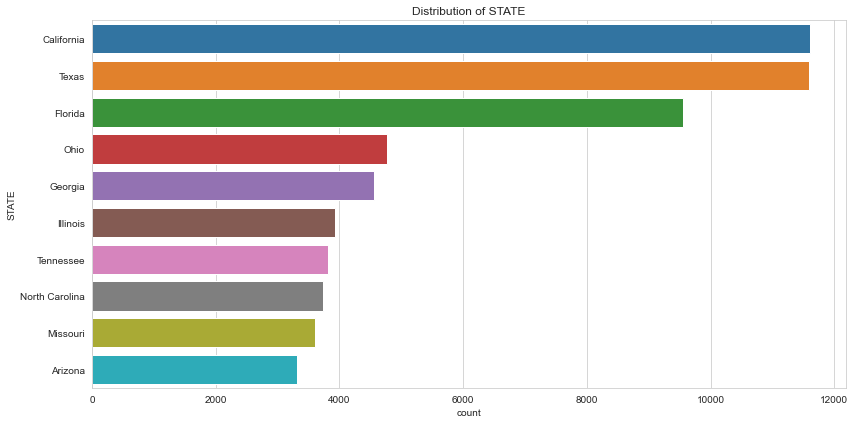

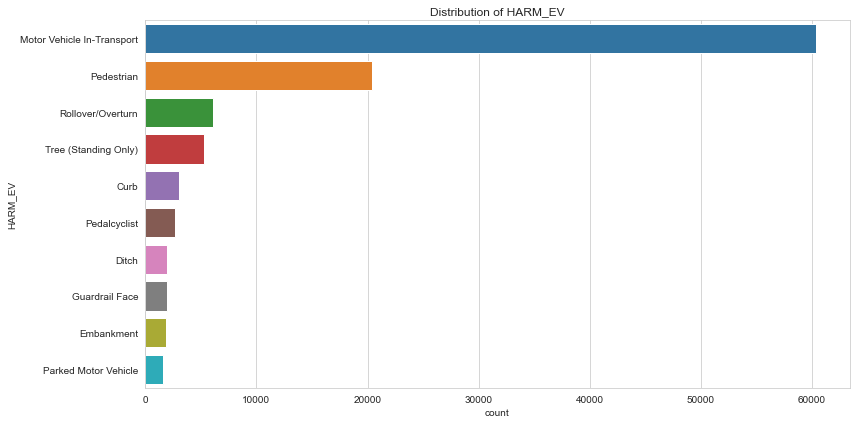

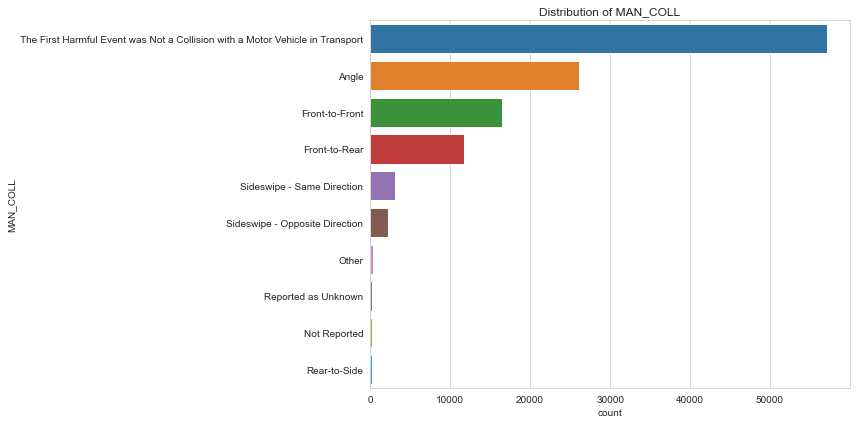

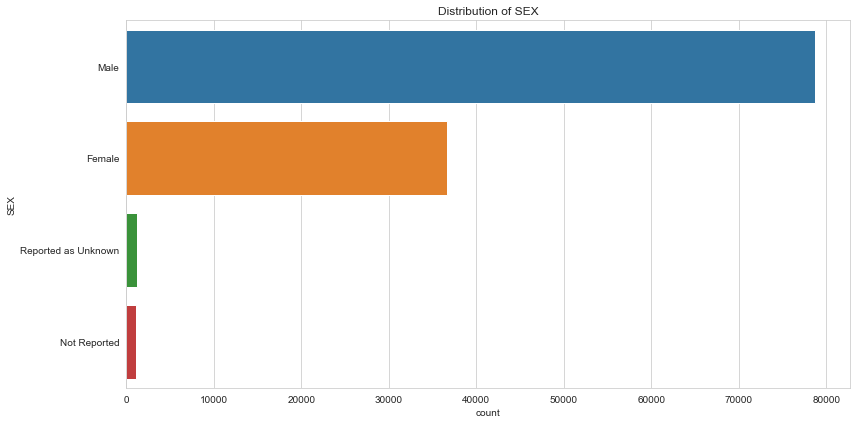

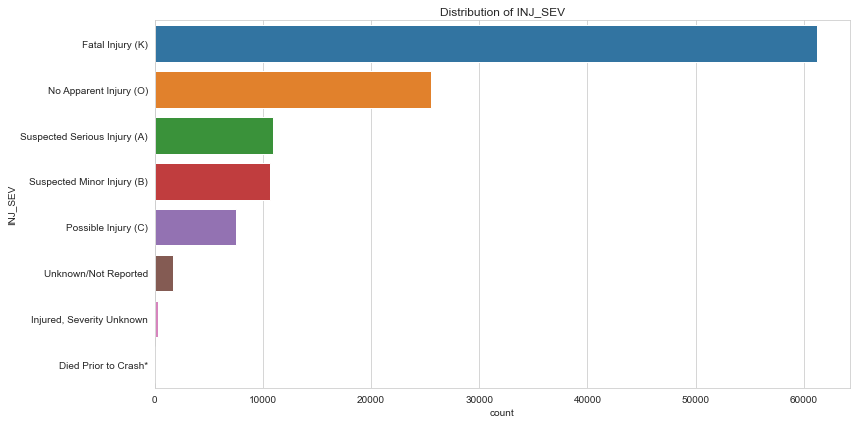

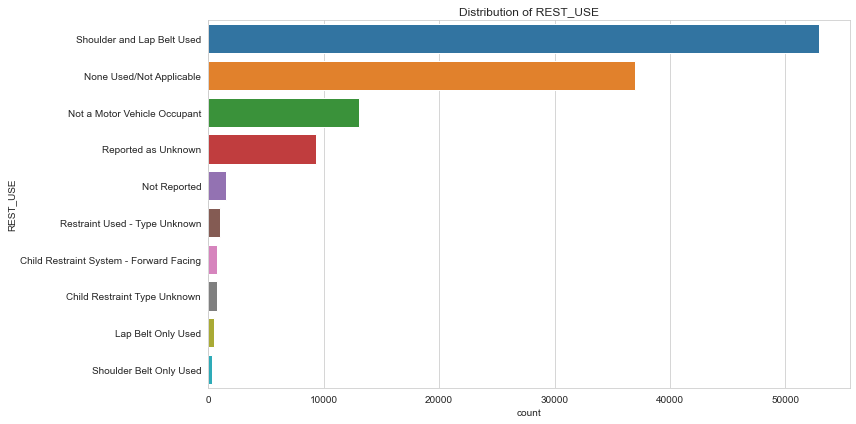

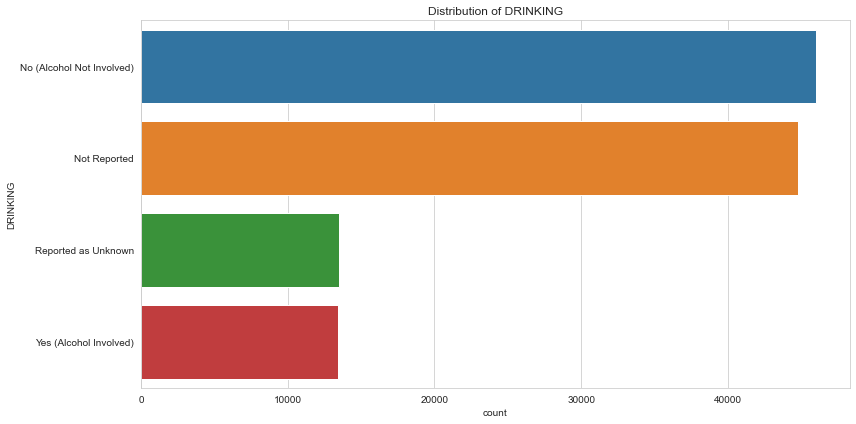

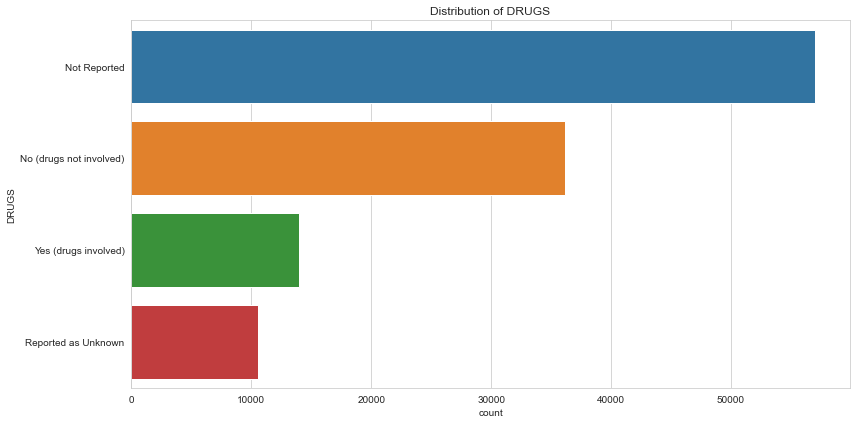

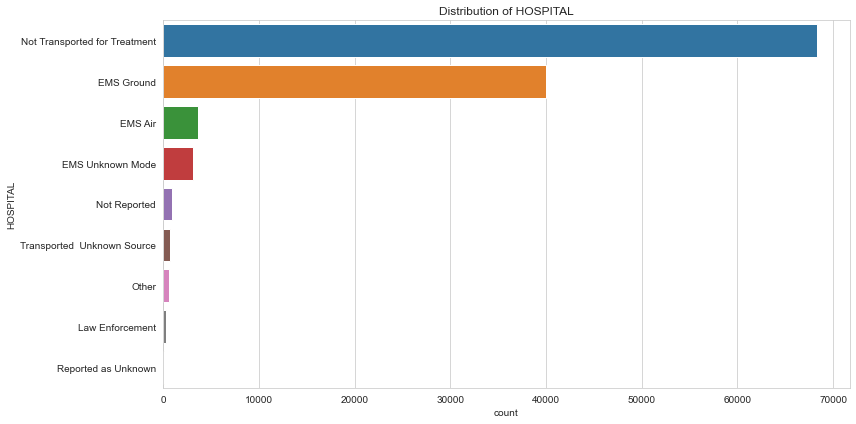

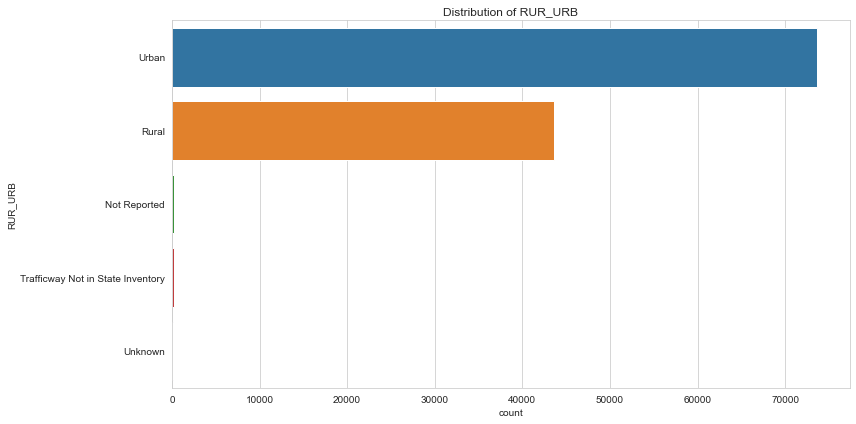

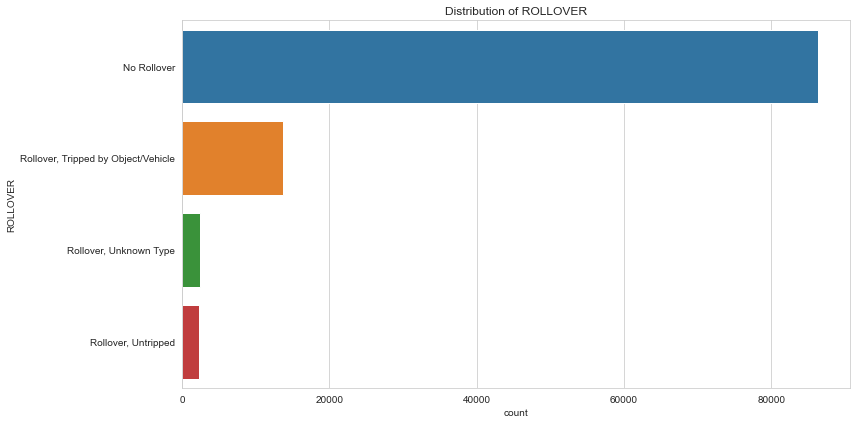

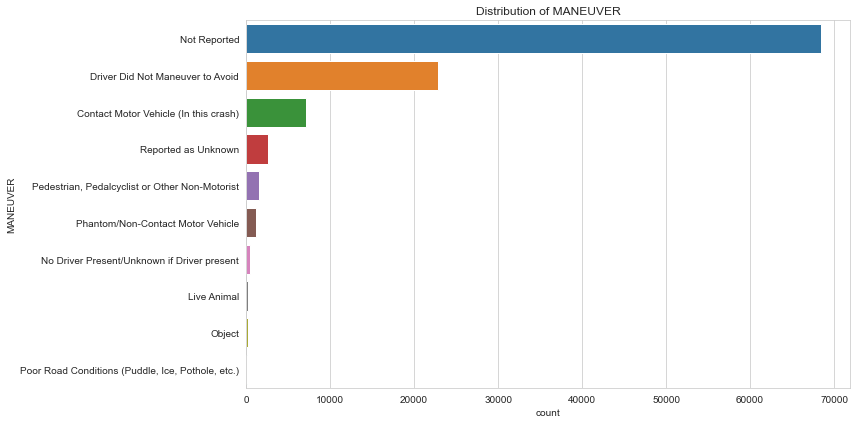

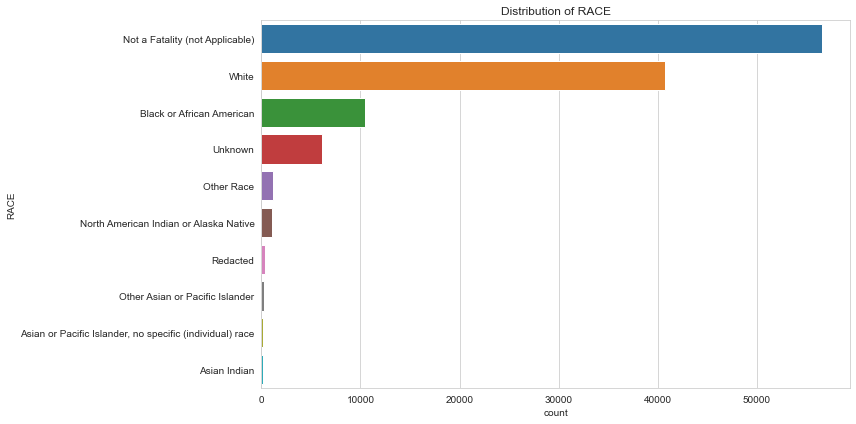

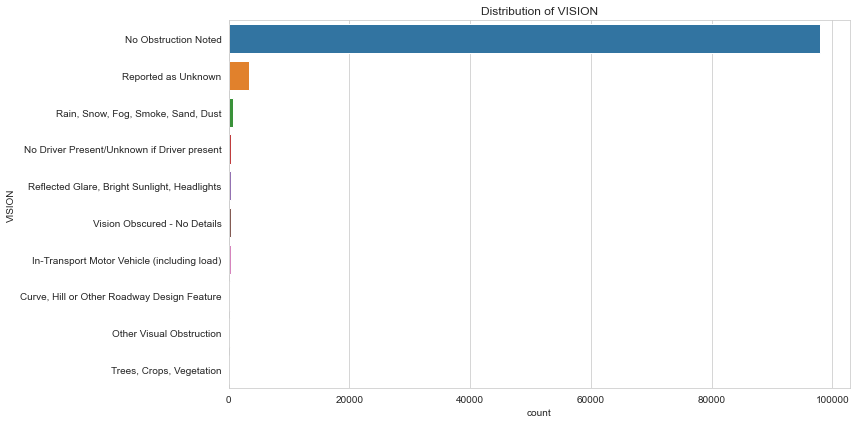

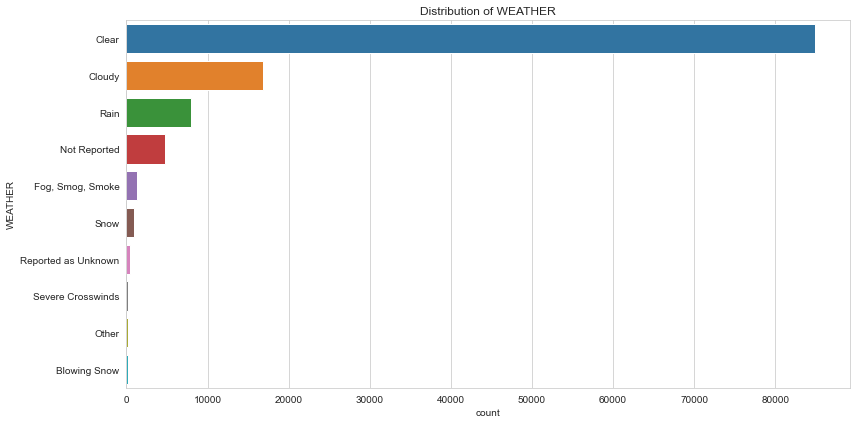

In [58]:
# Categorical Data
cat_cols = ['STATE', 'HARM_EV', 'MAN_COLL', 'SEX', 'INJ_SEV', 'REST_USE', 'DRINKING', 'DRUGS', 'HOSPITAL', 'RUR_URB', 'ROLLOVER', 'MANEUVER', 'RACE', 'VISION', 'WEATHER']
for col in cat_cols:
    plt.figure(figsize=(12,6))
    
    # Create a temporary dataframe for visualization
    temp_df = pd.DataFrame()
    temp_df[col] = df[col]
    
    # Replace numerical values with their corresponding names
    if col in dictionaries:
        temp_df[col] = temp_df[col].map(dictionaries[col])
    
    # Display only the top 10 categories if there are many unique categories
    top_categories = temp_df[col].value_counts().index[:10]
    sns.countplot(data=temp_df, y=col, order=top_categories)
    
    plt.title(f'Distribution of {col}')
    plt.tight_layout()  # Adjust the space allocation for y-axis labels
    plt.show()

In [63]:
dictionaries["DRUGS"]

{8.0: 'Not Reported',
 0.0: 'No (drugs not involved)',
 9.0: 'Reported as Unknown',
 1.0: 'Yes (drugs involved)'}

In [65]:
df["DRUGS"].value_counts()

8.0    57035
0.0    36174
1.0    13958
9.0    10565
Name: DRUGS, dtype: int64